In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, Trainer, TrainingArguments
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [5]:
print(f"Original classifier: {model.classifier}")  # Should show a layer with 5 outputs

Original classifier: Linear(in_features=768, out_features=5, bias=True)


In [6]:
model.num_labels = 3
model.classifier = nn.Linear(model.config.hidden_size, 3)

In [7]:
print(f"Updated classifier: {model.classifier}")  # Should now show 3 outputs

Updated classifier: Linear(in_features=768, out_features=3, bias=True)


# Finetune BERT

### Comments

In [8]:
def relabel(file):
    df = pd.read_csv(file)
    print(df.head(5))

    df = df.rename(columns={'sentiment': 'label'})

    def map_labels(rating):
        if rating == "negative":
            return 0  # Negative
        elif rating == "neutral":
            return 1  # Neutral
        else:
            return 2

    df['label'] = df['label'].apply(map_labels)
    return df

In [13]:
# df2020_all = relabel('./r_labeled_comments_2020.csv')
# df2024_all = relabel('./r_labeled_comments_2024.csv')

df2020 = relabel('./labeled_comments_2020.csv')
df2024 = relabel('./labeled_comments_2024.csv')

                                                text  created_utc  ups  \
0  Very true, but the problem is that even at tha...   1590975768    1   
1  You’re full of crap.\r\n\r\nYou present no fac...   1590984758    2   
2  Politically speaking, there is absolutely no w...   1590995791   29   
3  This is what happens when the president of the...   1591008451    1   
4  Silly comment. No matter how bad a president h...   1591013669    1   

   subreddit    neg    neu    pos  compound sentiment  
0  democrats  0.239  0.645  0.116   -0.9769  negative  
1  democrats  0.163  0.692  0.145   -0.1101  negative  
2  democrats  0.062  0.823  0.115    0.9925  positive  
3  democrats  0.000  0.903  0.097    0.4215  positive  
4  democrats  0.261  0.647  0.092   -0.8060  negative  
                                                text  created_utc  ups  \
0  They sure are making the rounds today. Our sys...   1717200019    1   
1  I would say it’s both. Because after a super c...   1717200509    6 

In [12]:
df2020 = df2020_all.sample(n=300, random_state = 42)
df2024 = df2024_all.sample(n=300, random_state = 42)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [14]:
df2020.head()

,text,created_utc,ups,subreddit,neg,neu,pos,compound,label
0,"Very true, but the problem is that even at tha...",1590975768,1,democrats,0.239,0.645,0.116,-0.9769,0
1,You’re full of crap.\r\n\r\nYou present no fac...,1590984758,2,democrats,0.163,0.692,0.145,-0.1101,0
2,"Politically speaking, there is absolutely no w...",1590995791,29,democrats,0.062,0.823,0.115,0.9925,2
3,This is what happens when the president of the...,1591008451,1,democrats,0.000,0.903,0.097,0.4215,2
4,Silly comment. No matter how bad a president h...,1591013669,1,democrats,0.261,0.647,0.092,-0.8060,0


In [15]:
# split into train and test data
def split_data(df2020, df2024):
    train_size = int(df2020.shape[0] * 0.8)
    test_size = min(df2020.shape[0] - train_size, df2024.shape[0])    # choose either 20% or the entirety of the df2024 data (whichever is smaller)

    train_df = df2020.sample(n=train_size, random_state=42)      # get random rows
    test_df = df2024.sample(n=test_size, random_state=42)

    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, test_dataset

train_dataset, test_dataset = split_data(df2020, df2024)

In [16]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [17]:
print(train_dataset[0])

{'text': "Eh, I think that's shortsighted. If someone kills trump, he becomes martyred and all of these protests will lose their power. The American people by and large are usually swayed towards the side of the victim. Right now, the victims are victims of police brutality. If we make the cops or president a bigger victim, public opinion will sway towards them.\r\n\r\nWe're all just bleeding hearts, at the end of the day. But our hearts bleed for different causes, and different victims. That's why non-violent protests are the number 1 way to go right now, along with writing letters to our representatives. I'm not saying non-violent acts are effective 100% of the time when it comes to producing change, but they do end up being on the morally just side of history more often than the violent acts. They killed Lincoln, and he freed the slaves, and now people side with Lincoln. They killed MLK, and he promoted civil rights, and now people side with MLK. The killers just don't end up as the

In [18]:
print(f"Classifier output size: {model.classifier.out_features}")
print(train_dataset['label'][:100])

Classifier output size: 3
[0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1]


In [ ]:
# train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [19]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    try:
        if logits.shape[1] == 2:
            probabilities = logits[:, 1]
            aucroc = roc_auc_score(labels, probabilities)
        else:
            aucroc = roc_auc_score(labels, logits, multi_class='ovr')
    except ValueError:
        aucroc = None

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_roc': aucroc
    }

In [27]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='./logs'
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

eval_log = None
trainer.train()
eval_log = trainer.evaluate()


print(f'Evaluation Log: {eval_log}')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-62e4fbc24f1b>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Auc Roc
1,0.201200,0.990759,0.600000,0.573563,None
2,0.141500,1.358186,0.625000,0.595040,None
3,0.105900,1.347529,0.525000,0.505506,None
4,0.096000,1.412024,0.550000,0.528571,None


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Evaluation Log: {'eval_loss': 1.3581855297088623, 'eval_accuracy': 0.625, 'eval_f1_score': 0.5950404858299596, 'eval_auc_roc': None, 'eval_runtime': 1.2167, 'eval_samples_per_second': 32.877, 'eval_steps_per_second': 2.466, 'epoch': 4.0}


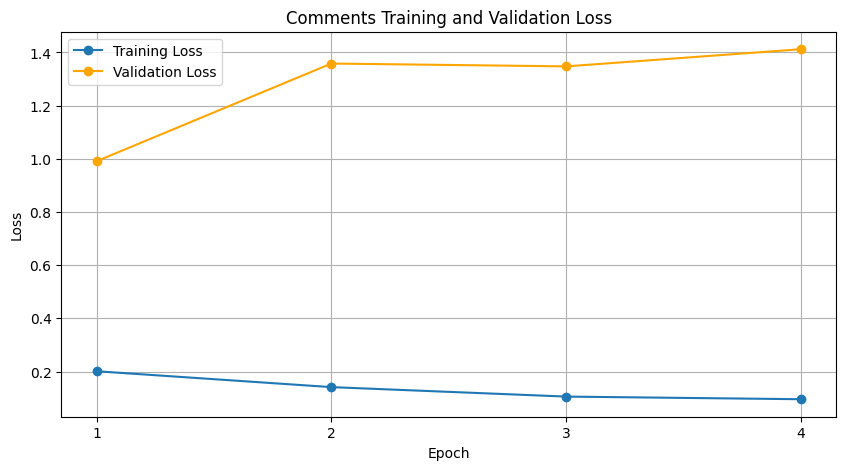

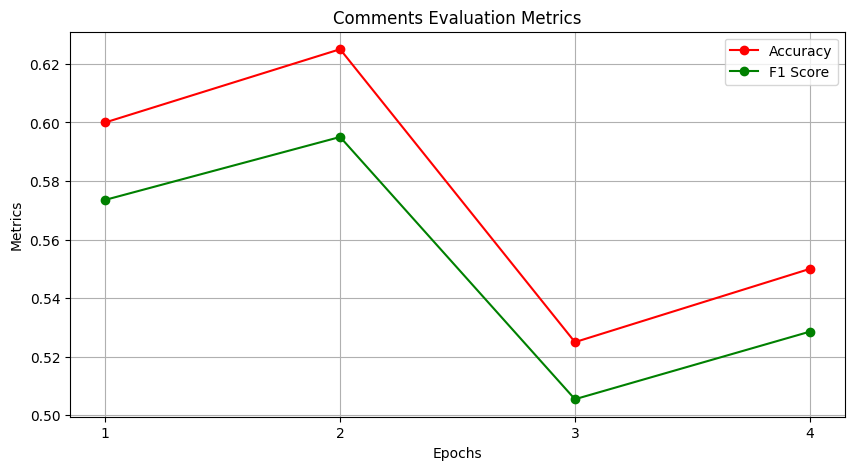

In [51]:
# Extract training and evaluation logs
log_history = trainer.state.log_history

# Extract metrics
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
epochs = range(1, len(train_loss)+1)   # 4

eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry][0:len(epochs)]
eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry][0:len(epochs)]
eval_f1 = [entry['eval_f1_score'] for entry in log_history if 'eval_f1_score' in entry][0:len(epochs)]
eval_auc_roc = [entry['eval_auc_roc'] for entry in log_history if 'eval_auc_roc' in entry][0:len(epochs)]

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Comments Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

# Plot evaluation metrics
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label='Accuracy', marker='o', color='red')
plt.plot(epochs, eval_f1, label='F1 Score', marker='o', color='green')
if eval_auc_roc[0] is not None:  # Only plot AUC-ROC if it's calculated
    plt.plot(epochs, eval_auc_roc, label='AUC-ROC', marker='o', color='blue')
plt.title('Comments Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

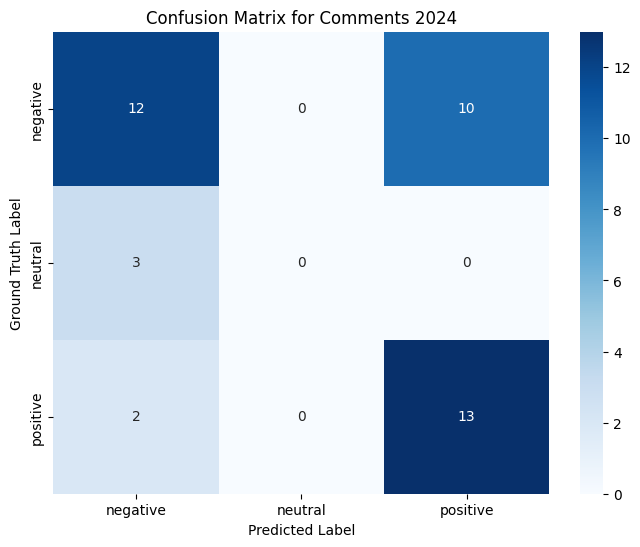

Accuracy: 62.5%


In [28]:
import numpy as np
labels = ['negative', 'neutral', 'positive']
# Get predictions on the test dataset using Trainer.predict()
predictions = trainer.predict(test_dataset)

# Extract predicted labels (argmax of the logits)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Extract true labels
true_labels = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Comments 2024')
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth Label')
plt.show()

print(f"Accuracy: {(accuracy_score(true_labels, pred_labels)) * 100}%")

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

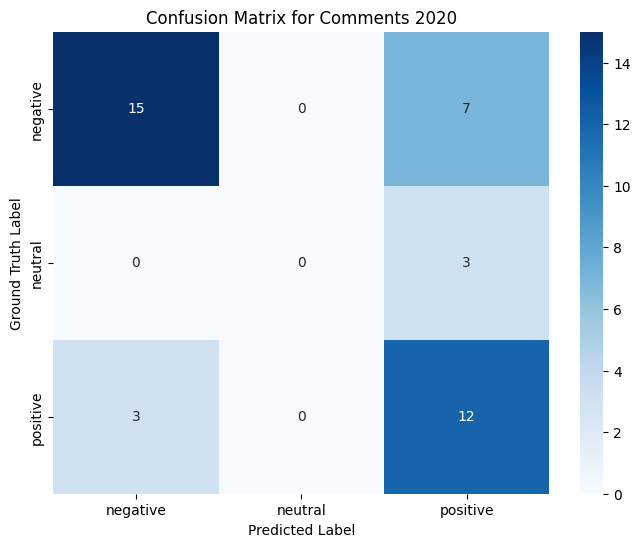

Accuracy: 67.5%


In [29]:
df_train_comments = df2020.sample(n=int(df2020.shape[0] * 0.8), random_state=42)
df_comments_2020 = pd.merge(df2020, df_train_comments, how='left', indicator=True)
df_comments_2020 = df_comments_2020[df_comments_2020['_merge'] == 'left_only'].drop(columns=['_merge'])
test_2020 = Dataset.from_pandas(df_comments_2020)
test_2020 = test_2020.map(tokenize_function, batched=True)
predictions = trainer.predict(test_2020)

# Extract predicted labels (argmax of the logits)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Extract true labels
true_labels = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Comments 2020')
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth Label')
plt.show()

print(f"Accuracy: {(accuracy_score(true_labels, pred_labels)) * 100}%")

### Posts

In [55]:
# pdf2020_all = relabel('./r_labeled_posts_2020.csv')
# pdf2024_all = relabel('./r_labeled_posts_2024.csv')
# pdf2020 = pdf2020_all.sample(n=300, random_state = 42)
# pdf2024 = pdf2024_all.sample(n=300, random_state = 42)
pdf2020 = relabel('./labeled_posts_2020.csv')
pdf2024 = relabel('./labeled_posts_2024.csv')

train_dataset, test_dataset = split_data(pdf2020, pdf2024)


train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

             selftext  created_utc  ups  subreddit link_flair_text  \
0                 NaN   1590994340    1  democrats             NaN   
1                 NaN   1591010811    1  democrats        See Note   
2  What am I missing?   1591011651   32  democrats             NaN   
3                 NaN   1591012889   49  democrats             NaN   
4                 NaN   1591025916    6  democrats         article   

                                               title  \
0  106,000 dead 40 mill unemployed Cities on fire...   
1  Why aren't Democrats calling for the president...   
2  Why aren't Democrats calling for the president...   
3  'Mr President, don't go hide': China goads US ...   
4  As Protests and Violence Spill Over, Trump Shr...   

                                                text    neg    neu    pos  \
0  106,000 dead 40 mill unemployed Cities on fire...  0.429  0.524  0.047   
1  Why aren't Democrats calling for the president...  0.239  0.761  0.000   
2  Why aren

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [56]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='./logs'
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

eval_log = None
trainer.train()
eval_log = trainer.evaluate()


print(f'Evaluation Log: {eval_log}')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-56-62e4fbc24f1b>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Auc Roc
1,1.043100,1.019856,0.525000,0.500000,None
2,0.578800,0.923370,0.600000,0.590806,None
3,0.377600,1.046822,0.650000,0.652500,None
4,0.268500,1.125438,0.625000,0.622839,None


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/auc_roc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Evaluation Log: {'eval_loss': 1.04682195186615, 'eval_accuracy': 0.65, 'eval_f1_score': 0.6525, 'eval_auc_roc': None, 'eval_runtime': 1.2542, 'eval_samples_per_second': 31.892, 'eval_steps_per_second': 2.392, 'epoch': 4.0}


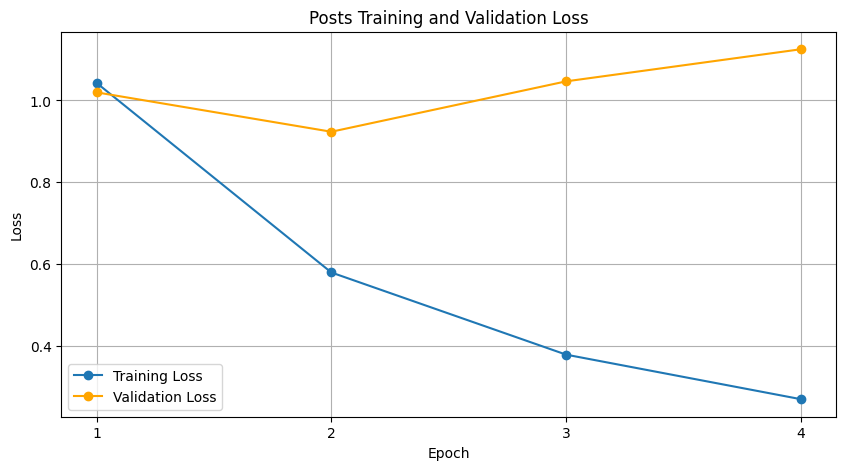

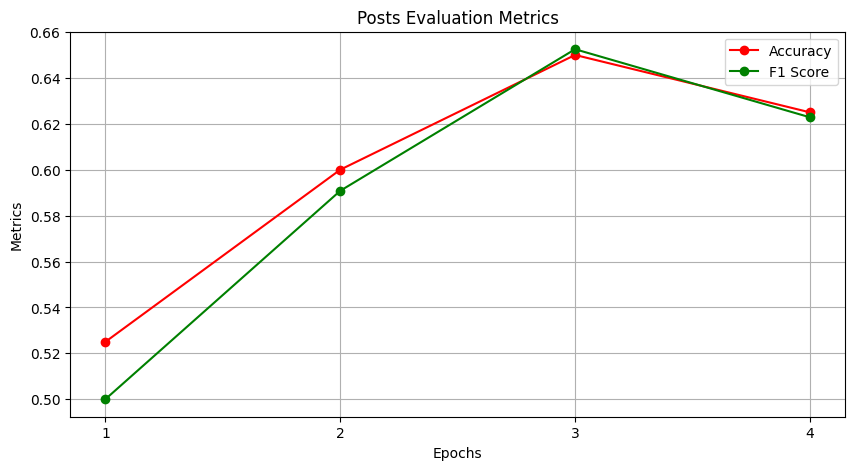

In [57]:
# Extract training and evaluation logs
log_history = trainer.state.log_history

# Extract metrics
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
epochs = range(1, len(train_loss)+1)   # 4

eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry][0:len(epochs)]
eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry][0:len(epochs)]
eval_f1 = [entry['eval_f1_score'] for entry in log_history if 'eval_f1_score' in entry][0:len(epochs)]
eval_auc_roc = [entry['eval_auc_roc'] for entry in log_history if 'eval_auc_roc' in entry][0:len(epochs)]

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Posts Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

# Plot evaluation metrics
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label='Accuracy', marker='o', color='red')
plt.plot(epochs, eval_f1, label='F1 Score', marker='o', color='green')
if eval_auc_roc[0] is not None:  # Only plot AUC-ROC if it's calculated
    plt.plot(epochs, eval_auc_roc, label='AUC-ROC', marker='o', color='blue')
plt.title('Posts Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

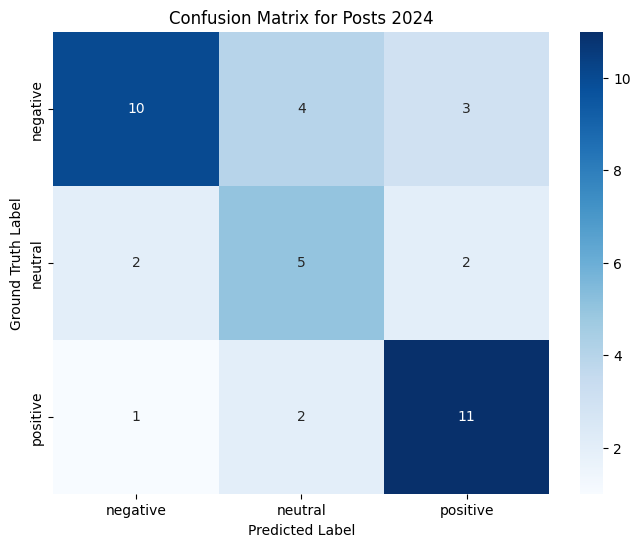

Accuracy: 65.0%


In [59]:
import numpy as np
labels = ['negative', 'neutral', 'positive']
# Get predictions on the test dataset using Trainer.predict()
predictions = trainer.predict(test_dataset)

# Extract predicted labels (argmax of the logits)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Extract true labels
true_labels = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Posts 2024')
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth Label')
plt.show()

print(f"Accuracy: {(accuracy_score(true_labels, pred_labels)) * 100}%")

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

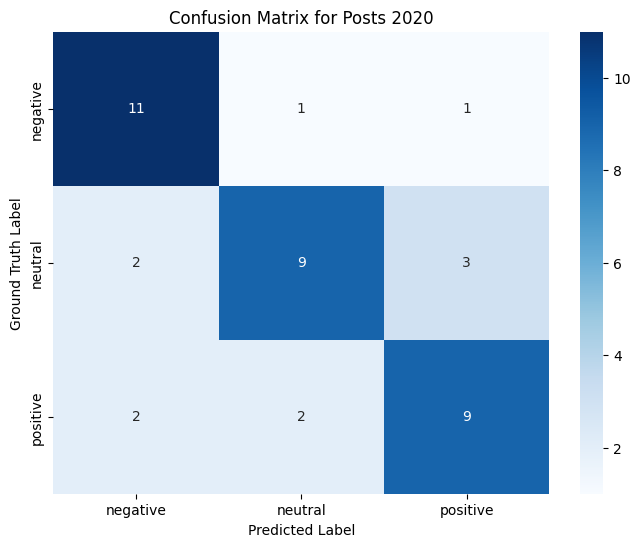

Accuracy: 72.5%


In [60]:
pdf_train_comments = pdf2020.sample(n=int(pdf2020.shape[0] * 0.8), random_state=42)
pdf_posts_2020 = pd.merge(pdf2020, pdf_train_comments, how='left', indicator=True)
pdf_posts_2020 = pdf_posts_2020[pdf_posts_2020['_merge'] == 'left_only'].drop(columns=['_merge'])
test_2020 = Dataset.from_pandas(pdf_posts_2020)
test_2020 = test_2020.map(tokenize_function, batched=True)
predictions = trainer.predict(test_2020)

# Extract predicted labels (argmax of the logits)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Extract true labels
true_labels = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Posts 2020')
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth Label')
plt.show()

print(f"Accuracy: {(accuracy_score(true_labels, pred_labels)) * 100}%")